In [91]:
import pandas as pd
pd.set_option('display.max_rows', 500)
import time
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')

# WirVsVirus Hackathon

Die entscheidende Frage bei der Beurteilung aller Maßnahmen ist, ob das exponentielle Wachstum verlangsamt worden ist, d.h. die exponentielle Wachstumskurve abflacht.
Dazu macht man am besten anhand bestehender Daten ein Modell-Fit und schaut, ob aktuelle Fallzahlen das Modell überschreiten oder man mit den Fallzahlen darunter bleibt.

## Download Data from CSSE COVID-19 Dataset

We are using the Covid-19 Dataset: https://github.com/CSSEGISandData/COVID-19

In [92]:
url = 'https://raw.githubusercontent.com'
url += '/CSSEGISandData/COVID-19'
url += '/master/csse_covid_19_data/csse_covid_19_time_series'
url += '/time_series_19-covid-Deaths.csv'
print('Downloading Data from %s' % url)

In [93]:
deaths_raw = pd.read_csv(url)

In [94]:
deaths_raw.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,NaN,Japan,36.0000,138.0000,0,0,0,0,0,0,...,16,19,22,22,27,29,29,29,33,35
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,...,0,0,0,0,0,2,2,2,3,4


### Preprocessing

In [95]:
deaths = deaths_raw[deaths_raw['Country/Region']=='Germany'].T
deaths = deaths[4:].astype('int')
deaths.columns = ['deaths']

In [96]:
deaths.index = pd.to_datetime(deaths.index)
deaths = deaths.asfreq('D')

Filter der Daten: Wir nehmen für die Modellbildung erst den Tag als Beginn, an dem erstmals mehr als 100 Erkrankte gemeldet waren.

In [97]:
deaths = deaths[deaths.deaths>=10]

## Modellvarianten

Man kann immer ein aktuelles Modell rechnen, oder schauen wie sich die Zahlen verändern, basierend auf einem Modell von einem festen Datum aus.

In [98]:
#today = deaths.index[-1] # immer aktuell rechnen
today = datetime.date(2020, 3, 21) # 21.03.2020 als Bezugsdatum nehme

## Feature

In [99]:
deaths['days'] = (deaths.index - deaths.index.min()).days

In [100]:
deaths.head()

,deaths,days
2020-03-15,11,0
2020-03-16,17,1
2020-03-17,24,2
2020-03-18,28,3
2020-03-19,44,4


## Ausgangssperren

Am Wochenende 20.03./21.03.2020 haben einige Gemeinden und Städte Ausgangssperren verhängt (z.B. [Dresden](https://www.dresden.de/media/pdf/presseamt/Allgemeinverfuegung.pdf), Mitterteich, ganz Bayern usw). Daher werden wir uns das Datum mal merken.

In [101]:
ausgangssperren_timestamp = datetime.date(2020, 3, 21)

In [102]:
ausgangssperren_timestamp_epoch = time.mktime(ausgangssperren_timestamp.timetuple())*1000

## Prediction Model

Ein exponentielles Wachstum (freie unkontrollierte Ausbreitung) verläuft nach:

$y = A e^{Bx}$

Wenn wir das logarithmieren mit dem Log zur Basis $e$, haben wir ein lineares Modell.

$\log_e(y) = B x + \log_e (A)$

In [103]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

In [104]:
X = deaths[:today]['days'].values.reshape(-1, 1)
y = deaths[:today]['deaths'].values
logy = np.log(y)

### Train

In [105]:
clf = LinearRegression()
clf.fit(X, logy)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [106]:
logy_pred = clf.predict(X)

Die mit dem linearen Modell vorhergesagten Werte sind im logarithmischen, müssen mit der $e^y$ noch zurück konvertiert werden.

In [107]:
deaths.loc[:today,'predicted_exp'] = np.exp(logy_pred).astype('int')

In [108]:
deaths.tail()

,deaths,days,predicted_exp
2020-03-17,24,2,22
2020-03-18,28,3,31
2020-03-19,44,4,44
2020-03-20,67,5,61
2020-03-21,84,6,86


### Modelparameter

In [109]:
B = clf.coef_[0]
A = np.exp(clf.intercept_)
print('Modellparameter sind A=%.1f, B=%.3f' % (A, B))

Modellparameter sind A=11.5, B=0.337


### Logistisches Wachstum

Anmerkung: Typischerweise ist nur der Beginn einer Epedemie mit exponentiellem Wachstum, denn irgendwann sind die Menschen immun oder verstorben und das Virus kann sich nicht weiter ausbreiten. Daher geht die Infektion in eine Sättigung. Die exponentielle Wachstumsfunktion geht in eine Logistische Funktion über:

$P(t) = \cfrac{K}{1+\left(\frac{K-P_0}{P_0}\right)e^{-rt}}$

mit:
* $P$ = Population, hier Infizierte
* $t$ = Tage
* $r$ = Wachstumsrate
* $K$ = Kapazität (Sättigung, da gehen wir von 70% der 81mio deutschen aus)
* $P_0$ = initial Infizierte am Tag 0

Hier können wir die gefundenen Modellparameter aus dem exponentiellen Wachstum nutzen.

In [110]:
infektionsrate = 0.7
gesamtanzahl = 81000000
sterberate = 0.05 # 5% !?

K = infektionsrate * gesamtanzahl * sterberate

In [111]:
def logistic_function(s, r=B, K=K, P0=A):
    t=s.days
    P = K / (1 + ((K-P0)/P0) * np.exp(-r*t))
    return int(P)

### Model Evaluation

R² score: the coefficient of determination

In [112]:
r2_score(deaths['deaths'].values, deaths['predicted_exp'].values)

0.9878581523833997

## Save the model for later use

In [113]:
import pickle

pklfilename = '%s-Germany-Covid19-Deaths-Prediction-Model.pkl' % today.strftime('%Y-%m-%d')
with open(pklfilename, 'wb') as f:
    pickle.dump(clf, f)
    
print('Saved the Model to %s' % pklfilename)

Saved the Model to 2020-03-21-Germany-Covid19-Deaths-Prediction-Model.pkl


## Future

In [114]:
fd = 30 # days into the future

In [115]:
# Create DataFrame in the Future
dates = pd.date_range(deaths.index[-1], periods=fd, closed='right')
days_in_future = deaths.days[-1] + np.arange(1, fd)

future = pd.DataFrame(data=days_in_future, index=dates, columns=['days'])

In [116]:
future = deaths.append(future, sort=True)

### Predict the Future

In [117]:
X_future = future['days'].values.reshape(-1, 1)

In [118]:
logy_pred = clf.predict(X_future)
future['predicted_exp'] = np.exp(logy_pred).astype('int')

In [119]:
future['predicted_log'] = future.apply(logistic_function, axis=1)

In [120]:
print(future)

            days  deaths  predicted_exp  predicted_log
2020-03-15     0    11.0             11             11
2020-03-16     1    17.0             16             16
2020-03-17     2    24.0             22             22
2020-03-18     3    28.0             31             31
2020-03-19     4    44.0             44             44
2020-03-20     5    67.0             61             61
2020-03-21     6    84.0             86             86
2020-03-22     7     NaN            121            121
2020-03-23     8     NaN            170            170
2020-03-24     9     NaN            238            238
2020-03-25    10     NaN            334            334
2020-03-26    11     NaN            469            469
2020-03-27    12     NaN            657            657
2020-03-28    13     NaN            921            921
2020-03-29    14     NaN           1291           1290
2020-03-30    15     NaN           1809           1808
2020-03-31    16     NaN           2535           2533
2020-04-01

## Future Plot

In [121]:
title = 'Todesfälle und Vorhersage für Deutschland (Basierend auf CSSE COVID-19 Dataset)'

Saved the Figure


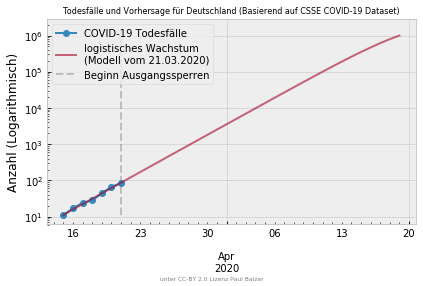

In [122]:
ax = future['deaths'].plot(label='COVID-19 Todesfälle', marker='o')
ax = future['predicted_log'].plot(label='logistisches Wachstum\n(Modell vom %s)' % today.strftime('%d.%m.%Y'),
                                  alpha=0.6, ax=ax)

ax.vlines(ausgangssperren_timestamp,
          ymin=future.predicted_exp.min(),
          ymax=future.predicted_exp.max(),
          linestyle='--', alpha=0.2, label='Beginn Ausgangssperren')

ax.legend()
ax.set_ylabel('Anzahl (Logarithmisch)')
ax.set_yscale('log')
ax.set_title(title, fontsize=8)
ax.annotate('unter CC-BY 2.0 Lizenz Paul Balzer', xy=(.5, 0.02), xycoords='figure fraction', ha='center', fontsize=6, color='gray')

plt.tight_layout()
plt.savefig('./%s-Germany-Covid19-Deaths-Prediction.png' % today.strftime('%Y-%m-%d'), dpi=150)
print('Saved the Figure')

## Export as Excel

In [123]:
xlsfile = './%s-Germany-Covid19-Deaths-Prediction.xlsx' % today.strftime('%Y-%m-%d')
future.to_excel(xlsfile)
print('Saved the Excel to %s' % xlsfile)

Saved the Excel to ./2020-03-21-Germany-Covid19-Deaths-Prediction.xlsx


# Interactive Website

We are using Bokeh to export an interactive website

In [124]:
from bokeh.plotting import figure
from bokeh.models.formatters import DatetimeTickFormatter, NumeralTickFormatter
from bokeh.models import Div, HoverTool, BoxAnnotation, Span
from bokeh.layouts import column
from bokeh.embed import file_html
from bokeh.resources import CDN
from bokeh.palettes import inferno

In [125]:
colors = inferno(6) # What else for this scenario ;)

In [136]:
p = figure(tools="hover,save,pan,box_zoom,reset,wheel_zoom",
           x_axis_type="datetime",
           title=title.replace(')', ' der John Hopkins University)'))

# Vertical line for Ausgangssperren
vline = Span(location=ausgangssperren_timestamp_epoch,
             dimension='height', line_color='gray',
             line_dash='dashed', line_width=3, name='Beginn Ausgangssperren')
p.add_layout(vline)

# Vorhersagemodell als Linie
p.line(future.index, future.predicted_log, line_width=4, line_color=colors[3],
       legend='logistisches Wachstum\n(Modell vom %s)' % today.strftime('%d.%m.%Y'))

# Tatsächliche Fälle als Punkte
p.circle(deaths.index, deaths.deaths, line_color=colors[4],
         fill_color=colors[5], size=14, legend='Bestätigte COVID-19 Todesfälle')

# Achsen ordentlich formatieren
p.xaxis.formatter=DatetimeTickFormatter(
    years="%d.%m.%Y",
    months="%d.%m.%Y",
    days="%A %d.%m.%Y",
)
p.yaxis.formatter=NumeralTickFormatter(format='0.0a')

p.yaxis.axis_label = 'Anzahl'

# Daten-Zeitraum
gray_box = BoxAnnotation(left=deaths.index[0],
                          right=deaths.index[-1],
                          fill_color='gray', fill_alpha=0.1)
p.add_layout(gray_box)

# Tooltips
p.select_one(HoverTool).tooltips = [
    ('Datum', '@x{%d.%m.%Y}'),
    ('Fälle', '@y{0.0a}'),
]
p.select_one(HoverTool).formatters = {'x':'datetime'}
p.select_one(HoverTool).mode = 'vline'

p.toolbar.autohide = True

# Legende
p.legend.location = "top_left"

# Anmerkung
div = Div(text="""Quellcode: <a href="https://github.com/balzer82/covid-germany-predictor">Covid Germany Predictor</a>
            unter CC-BY2.0 Lizenz von Paul Balzer on Github.
            Disclaimer: Ich bin kein Epidemiologe oder Virologe, das ist keine offizielle Vorausberechnung! 
            Es wurde ein exponentielles Wachstumsmodell mittels Least Square auf die gemeldeten Fälle gefittet,
            anschließend wurden diese Parameter auf eine logistische Funktion angewendet, welche mit %i%% Infektionsrate
            unter %imio Deutschen in die Sättigung geht und dabei %i%% Sterblichkeit auftritt.
            <a href="https://cbcity.de/impressum">Impressum</a>""" % (infektionsrate*100, gesamtanzahl/1e6, sterberate*100))

# Save
html = file_html(column(p, div, sizing_mode="stretch_both"), CDN, 'COVID-19 Prediction Germany')

## Style the Website

In [137]:
head = '''
  <body>
        <div><img src="https://wirvsvirushackathon.org/wp-content/uploads/2020/03/12-scaled.jpg" style="height: 30px; padding: 10px;"></div>
'''

In [138]:
gtc = '''
        <!-- Global site tag (gtag.js) - Google Analytics -->
        <script async src="https://www.googletagmanager.com/gtag/js?id=UA-7230698-7"></script>
        <script>
          window.dataLayer = window.dataLayer || [];
          function gtag(){dataLayer.push(arguments);}
          gtag('js', new Date());

          gtag('config', 'UA-7230698-7');
        </script>
    </body>
'''

In [139]:
websitehtml = html.replace('<body>', head)
websitehtml = websitehtml.replace('</body>', gtc)

In [140]:
with open('./html/index2.html', 'w') as htmlfile:
    htmlfile.write(websitehtml.strip())

print('Saved the /html/index2.html')

Saved the /html/index2.html


CC-BY 2.0 Paul Balzer